In [1]:
import pickle
import sys
sys.path.extend(['C:\\git\\thesis_clean_v2'])
from OriKerasExtension.ThesisHelper import readCompleteMatFile, ExtractDataVer4
from experiments.pretrained_by_colors.color_utils import create_color_dictionary, get_color_from_stimuli
from keras.utils.np_utils import to_categorical
from scipy import stats


In [2]:
results = pickle.load(  open( r"C:\git\thesis_clean_v2\experiments\pretrained_by_colors\save_28_april_predict_color_all_subjects_aggregated_except_one.p", "rb" ) )

In [3]:
len(results)

11

In [26]:



def downsample_data(data, number_of_original_samples, down_samples_param):
    new_number_of_time_stamps = number_of_original_samples / down_samples_param

    temp_data_for_eval = np.zeros((data.shape[0], new_number_of_time_stamps, data.shape[2]))

    for new_i, i in enumerate(range(0, number_of_original_samples, down_samples_param)):
        temp_data_for_eval[:, new_i, :] = np.mean(data[:, range(i, (i + down_samples_param)), :], axis=1)
    return temp_data_for_eval

def create_letter_test_data_color(gcd_res, down_samples_param, jitter=20):
    last_time_stamp = 800 + jitter
    fist_time_stamp = -200 +jitter
    color_dictionary = create_color_dictionary()
    data_for_eval = ExtractDataVer4(gcd_res['all_relevant_channels'], gcd_res['marker_positions'],
                                    gcd_res['target'], fist_time_stamp, last_time_stamp)

    print data_for_eval[0].shape
    temp_data_for_eval = downsample_data(data_for_eval[0], data_for_eval[0].shape[1], down_samples_param)

    all_data = temp_data_for_eval[np.all([gcd_res['train_mode'] == 2], axis=0)]

    categorical_tags = to_categorical(
        get_color_from_stimuli(gcd_res['stimulus'][gcd_res['train_mode'] == 2], color_dictionary))
    shuffeled_samples, suffule_tags = (all_data, categorical_tags)
    return shuffeled_samples, suffule_tags

In [5]:
from keras.layers import Convolution2D, Activation, MaxPooling2D, Flatten, Dense, LSTM, Dropout
from keras.models import Sequential
from keras.regularizers import l2



Using Theano backend.
Using gpu device 0: GeForce GT 740M (CNMeM is disabled, CuDNN not available)
C:\Anaconda\lib\site-packages\theano\tensor\signal\downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [6]:
"""
define the neural network model:
"""
model_lstm = Sequential()

model_lstm.add(LSTM(input_dim=55, output_dim=20, return_sequences=True))
model_lstm.add(Dropout(0.01))
model_lstm.add(LSTM(input_dim=20, output_dim=20, return_sequences=False))
#     model_lstm.add(Dropout(0.01))
#     model_lstm.add(LSTM(input_dim=20, output_dim=20,return_sequences=False))
model_lstm.add(Dense(5, W_regularizer=l2(0.006)))
model_lstm.add(Activation('softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop',)



In [7]:
import keras
"""
define the neural network model:
"""
model_mpl = Sequential()
model_mpl.add(keras.layers.core.Flatten(input_shape=(55, 25)))
model_mpl.add(Dense(input_dim=55 * 25, output_dim=20))
model_mpl.add(Dropout(0.3))
model_mpl.add(Activation('tanh'))
model_mpl.add(Dense(output_dim=20, W_regularizer=l2(0.06)))
model_mpl.add(Activation('tanh'))
model_mpl.add(Dense(5))
model_mpl.add(Activation('softmax'))
model_mpl.compile(loss='categorical_crossentropy', optimizer='rmsprop')

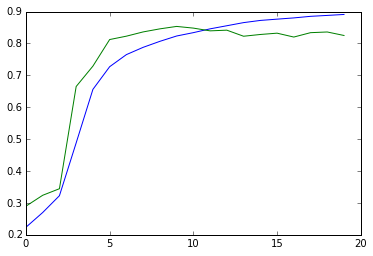

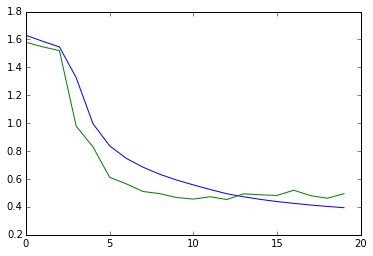

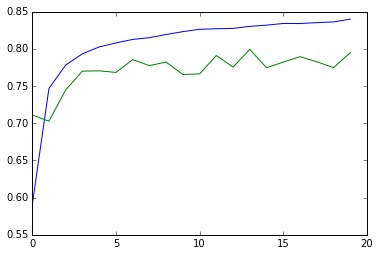

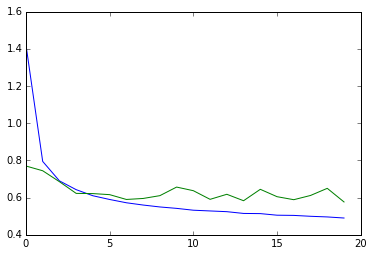

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline 
# print results[0][0]
# print results[0]['lstm_history']['val_accuracies'][-1]
# print results[0]['mlp_history']['val_accuracies'][-1]
# print results[0]['mlp_history'].keys()
counter = 4
plt.plot(results[counter][0]['lstm_history']['train_accuracies'])
plt.plot(results[counter][0]['lstm_history']['val_accuracies'])
plt.show()

plt.plot(results[counter][0]['lstm_history']['train_losses'])
plt.plot(results[counter][0]['lstm_history']['val_losses'])
plt.show()


plt.plot(results[counter][0]['mlp_history']['train_accuracies'])
plt.plot(results[counter][0]['mlp_history']['val_accuracies'])
plt.show()

plt.plot(results[counter][0]['mlp_history']['train_losses'])
plt.plot(results[counter][0]['mlp_history']['val_losses'])
plt.show()


In [28]:
import numpy as np

data_set_locations = ["RSVP_Color83msVPicr.mat",
                      "RSVP_Color83msVPpia.mat",
                      "RSVP_Color83msVPfat.mat",
                      "RSVP_Color83msVPgcb.mat",
                      "RSVP_Color83msVPgcc.mat",
                      "RSVP_Color83msVPgcd.mat",
                      "RSVP_Color83msVPgcf.mat",
                      "RSVP_Color83msVPgcg.mat",
                      "RSVP_Color83msVPgch.mat",
                      "RSVP_Color83msVPiay.mat",
                      "RSVP_Color83msVPicn.mat"];


data_set_locations = ["RSVP_Color116msVPicr.mat",
                      "RSVP_Color116msVPpia.mat",
                      "RSVP_Color116msVPfat.mat",
                      "RSVP_Color116msVPgcb.mat",
                      "RSVP_Color116msVPgcc.mat",
                      "RSVP_Color116msVPgcd.mat",
                      "RSVP_Color116msVPgcf.mat",
                      "RSVP_Color116msVPgcg.mat",
                      "RSVP_Color116msVPgch.mat",
                      "RSVP_Color116msVPiay.mat",
                      "RSVP_Color116msVPicn.mat"];

lstm_accuracy = []
mlp_accuracy = []

for i, subject_name in enumerate(data_set_locations):
    model_lstm.set_weights(results[i][0]['lstm_history']['weights'])
    model_mpl.set_weights(results[i][0]['mlp_history']['weights'])
    file_name = r'C:\Users\ORI\Documents\Thesis\dataset_all\{0}'.format(subject_name)
    gcd_res = readCompleteMatFile(file_name)
    jitter = 0
#     for jitter in range(-50,50,25):
    single_subject_test_data, single_subject_test_tags = create_letter_test_data_color(gcd_res, down_samples_param=8,jitter=jitter)
    
    lstm_eval_res = model_lstm.evaluate(stats.zscore(single_subject_test_data, axis=1),single_subject_test_tags, show_accuracy=True)
    mlp_eval_res = model_mpl.evaluate(stats.zscore(single_subject_test_data, axis=1),single_subject_test_tags, show_accuracy=True)
    print lstm_eval_res
    print mlp_eval_res
    lstm_accuracy.append([subject_name,lstm_eval_res[1]])
    mlp_accuracy.append([subject_name,mlp_eval_res[1]])
    


(18600L, 200L, 55L)
6000/6000 [==============================] - 0s     
[1.0990880746841432, 0.62333333333333329]
[1.2275035673777261, 0.62316666666666665]
(20700L, 200L, 55L)
6000/6000 [==============================] - 0s     
[1.2801186602910359, 0.54716666666666669]
[1.4521771306991578, 0.5601666666666667]
(18600L, 200L, 55L)
6000/6000 [==============================] - 0s     
[0.43999695173899334, 0.84866666666666668]
[0.4018290739059448, 0.85716666666666663]
(19500L, 200L, 55L)
6000/6000 [==============================] - 0s     
[0.4747388205528259, 0.83850000000000002]
[0.36895943760871885, 0.86150000000000004]
(18300L, 200L, 55L)
6000/6000 [==============================] - 0s     
[0.45805621512730915, 0.85266666666666668]
[0.52908132632573446, 0.8075]
(21000L, 200L, 55L)
6000/6000 [==============================] - 0s     
[0.62155304527282718, 0.77349999999999997]
[0.78513268438975015, 0.73816666666666664]
(18600L, 200L, 55L)
6000/6000 [==============================] - 0

In [29]:
print accuracy

NameError: name 'accuracy' is not defined

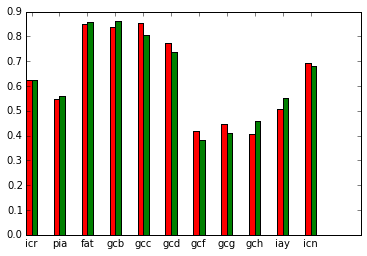

In [30]:
fig, ax = plt.subplots()

ind = np.arange(len(lstm_accuracy))
width = 0.2
rects1 = ax.bar(ind + width,[x[1]for x in mlp_accuracy],width,color='g')
rects1 = ax.bar(ind,[x[1]for x in lstm_accuracy],width,color='r')
ax.set_xticks(ind + width)
ax.set_xticklabels([x[0][-7:-4] for x in lstm_accuracy])
plt.show()

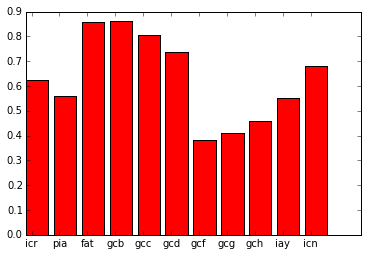

In [31]:
fig, ax = plt.subplots()
rects1 = ax.bar(ind,[x[1]for x in mlp_accuracy],color='r')
ax.set_xticks(ind + width)
ax.set_xticklabels([x[0][-7:-4] for x in lstm_accuracy])
plt.show()